Welcome to your assignment this week! 

To better understand adverse attacks againsts AI and how it is possible to fool an AI system, in this assignment, we will look at a Computer Vision use case. 




This assessment creates an *adversarial example* using the Fast Gradient Signed Method (FGSM) attack as described in [Explaining and Harnessing Adversarial Examples](https://arxiv.org/abs/1412.6572) by Goodfellow *et al*. This was one of the first and most popular attacks to fool a neural network. 

# What is an adversarial example?

Adversarial examples are specialised inputs created with the purpose of confusing a neural network, resulting in the misclassification of a given input. These notorious inputs are indistinguishable to the human eye, but cause the network to fail to identify the contents of the image. There are several types of such attacks, however, here the focus is on the fast gradient sign method attack, which is a *white box* attack whose goal is to ensure misclassification. A white box attack is where the attacker has complete access to the model being attacked.

# Fast gradient sign method
The fast gradient sign method works by using the gradients of the neural network to create an adversarial example. For an input image, the method uses the gradients of the loss with respect to the input image to create a new image that maximises the loss. This new image is called the adversarial image. This can be summarised using the following expression:
$$adv\_x = x + \epsilon*\text{sign}(\nabla_xJ(\theta, x, y))$$

where 

*   adv_x : Adversarial image.
*   x : Original input image.
*   y : Original input label.
*   $\epsilon$ : Multiplier to ensure the perturbations are small.
*   $\theta$ : Model parameters.
*   $J$ : Loss.

An intriguing property here, is the fact that the gradients are taken with respect to the input image. This is done because the objective is to create an image that maximises the loss. A method to accomplish this is to find how much each pixel in the image contributes to the loss value, and add a perturbation accordingly. This works pretty fast because it is easy find how each input pixel contributes to the loss, by using the chain rule, and finding the required gradients. Hence, the gradients are used with respect to the image. In addition, since the model is no longer being trained (thus the gradient is not taken with respect to the trainable variables, i.e., the model parameters), and so the model parameters remain constant. The only goal is to fool an already trained model.



# Part 1

So let's try and fool a pretrained model. In this first part, the model is [MobileNetV2](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/applications/MobileNetV2) model, pretrained on [ImageNet](http://www.image-net.org/).




Run the following cell to load the packages you will need.

In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False


Let's load the pretrained MobileNetV2 model and the ImageNet class names.

In [2]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

In [3]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    image = image[None, ...]
    return image

#  Helper function to extract labels from probability vector
def get_imagenet_label(probs):
    return decode_predictions(probs, top=5)[0]


## Original image
Let's use a sample image of a [Labrador Retriever](https://commons.wikimedia.org/wiki/File:YellowLabradorLooking_new.jpg) -by Mirko       [CC-BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/) from Wikimedia Common and create adversarial examples from it. The first step is to preprocess it so that it can be fed as an input to the MobileNetV2 model.

In [4]:
image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)


1/1 [==============================] - 1s 905ms/step


Let's have a look at the image.

['Labrador_retriever', 'Eskimo_dog', 'Ibizan_hound', 'golden_retriever', 'Saluki']


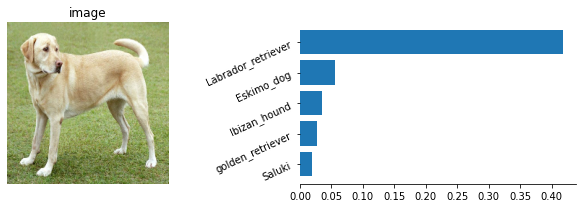

In [5]:
top5 = get_imagenet_label(image_probs)
tick_names = [x[1] for x in top5]
print(tick_names)
probs = [x[2] for x in top5]
plt.figure(figsize=(9, 3))
plt.subplot(121)
plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
plt.title('image')
ax = plt.gca()
ax.axis('off')

plt.subplot(122)
tick_names = [x[1] for x in reversed(top5)]
probs = [x[2] for x in reversed(top5)]
plt.barh(tick_names, probs)
plt.yticks(rotation=25)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.tight_layout()
plt.show()


# Create the adversarial image

## Implementing fast gradient sign method
The first step is to create perturbations which will be used to distort the original image resulting in an adversarial image. As mentioned, for this task, the gradients are taken with respect to the image.

**TASK 1:** Implement `create_adversarial_pattern()`. You will need to carry out 3 steps:

1. Create a loss object using `loss_object` using two arguments: `pretrained_model` and `input_label`.
2. Get the gradients using `tf.gradients` of the `loss`  w.r.t to the `input_image`.
3. Get the sign of the gradients to create the perturbation using `tf.sign`.


In [6]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
    ## START YOU CODE HERE (3 lines)
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = pretrained_model(input_image)
        loss = loss_object(input_label, prediction)
        
    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    # END
    return signed_grad

The resulting perturbations can also be visualised.

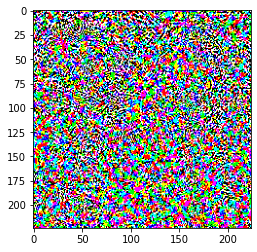

In [7]:
# Get the input label of the image.
labrador_retriever_index = 208
label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]


## Fool the AI system

Let's try this out for different values of epsilon and observe the resultant image. You'll notice that as the value of epsilon is increased, it becomes easier to fool the network, however, this comes as a trade-off which results in the perturbations becoming more identifiable.

In [8]:
def display_images(image, description):
    top5 = get_imagenet_label(pretrained_model.predict(image))
    top5 = list(reversed(top5))
    plt.figure(figsize=(9, 3))
    plt.subplot(121)
    plt.imshow(image[0]*0.5+0.5)
    plt.title(description)
    plt.gca().axis('off')
    plt.subplot(122)
    tick_names = [x[1] for x in top5]
    probs = [x[2] for x in top5]
    plt.barh(tick_names, probs)
    plt.yticks(rotation=25)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.tight_layout()
    plt.show()

**TASK 2:** Generate adverse image using different values for $\epsilon$:

- adv_x = input_image + $\epsilon$ * perturbations


1/1 [==============================] - 0s 51ms/step


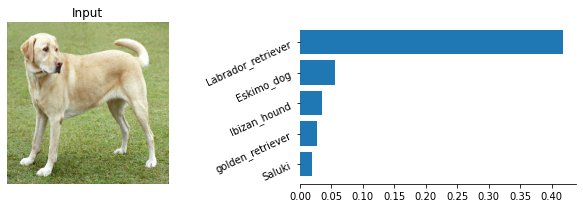

1/1 [==============================] - 0s 53ms/step


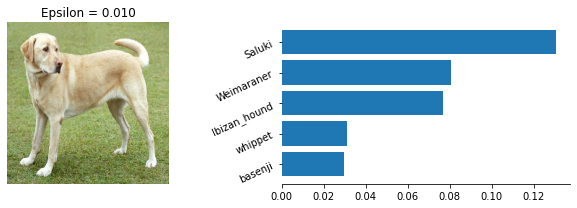

1/1 [==============================] - 0s 56ms/step


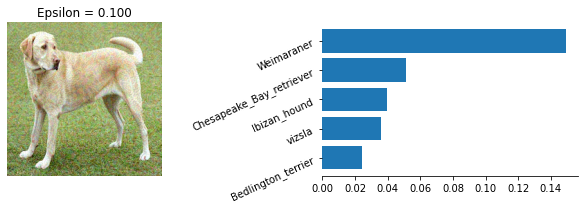

1/1 [==============================] - 0s 48ms/step


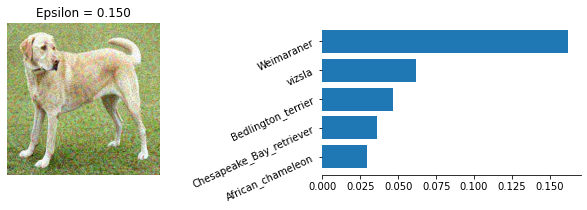

1/1 [==============================] - 0s 47ms/step


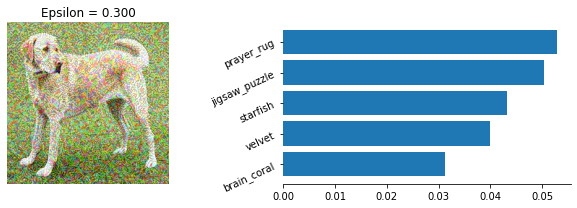

In [9]:
epsilons = [0, 0.01, 0.1, 0.15, 0.3]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
    ## START YOU CODE HERE
    adv_x = image + eps * perturbations
    ## End
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    display_images(adv_x, descriptions[i])



**TASK 3: What do you abserve?**

***

As epsilon increases, the adversarial perturbations become more visible in the image, and the model is more likely to misclassify the image. With small epsilon values, the changes are almost imperceptible to the human eye, but the model can still be fooled. As epsilon gets larger, the image becomes increasingly distorted, making the attack more obvious but also more effective at causing misclassification. This demonstrates the vulnerability of neural networks to adversarial attacks, even with very subtle changes.

***

#  Part 2

Here, you are required to process adversarial attacks using FGSM for a small subset of [ImageNet Dataset](http://www.image-net.org/). We prepared 100 images from different categories (in `./input_dir/`), and the labels are encoded in `./input_dir/clean_image.list`.

For evaluation, each adversarial image generated by the attack model will be fed to an evaluation model, and we will calculate the successful rate of adversarial attacks. **The adversarial images that can fool the evaluation model with $\epsilon$ = 0.01 will be considered as a success**.



**Task 4: Goal**

***

With the previous FGSM example, you are required to implement an FGSM attack against all examples and calculate the success rate. Also, display the original image with the attacked image as well as the predicted class for each image.


1/1 [==============================] - 0s 46ms/step


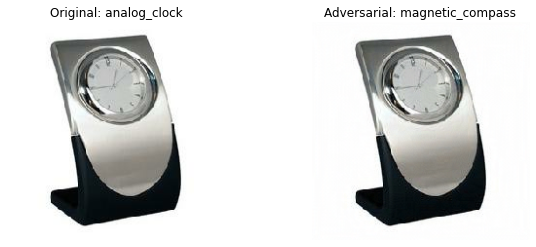

Processed 1/100 images
1/1 [==============================] - 0s 56ms/step


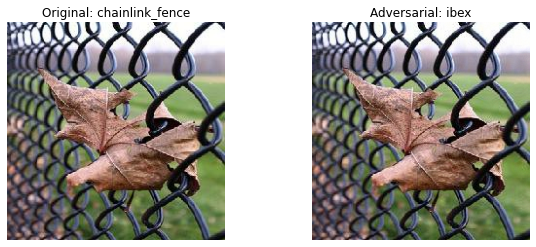

1/1 [==============================] - 0s 63ms/step


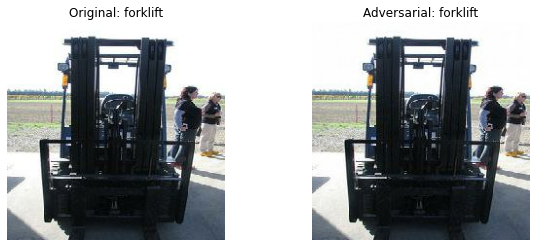

1/1 [==============================] - 0s 45ms/step


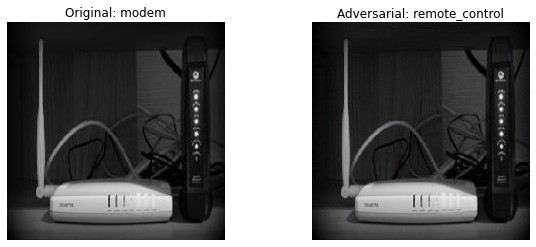

1/1 [==============================] - 0s 45ms/step


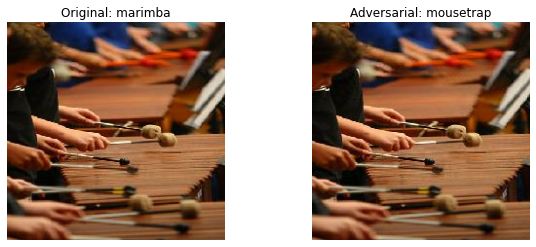

1/1 [==============================] - 0s 47ms/step
Processed 11/100 images
1/1 [==============================] - 0s 50ms/step
Processed 21/100 images
1/1 [==============================] - 0s 53ms/step
Processed 31/100 images
1/1 [==============================] - 0s 47ms/step
Processed 41/100 images
1/1 [==============================] - 0s 46ms/step
Processed 51/100 images
1/1 [==============================] - 0s 33ms/step
Processed 61/100 images
1/1 [==============================] - 0s 41ms/step
Processed 71/100 images
1/1 [==============================] - 0s 33ms/step
Processed 81/100 images
1/1 [==============================] - 0s 41ms/step
Processed 91/100 images
1/1 [==============================] - 0s 48ms/step
Successful adversarial attacks (epsilon=0.01): 78/100 (78.00%)


In [10]:
input_dir = './input_dir/'
label_file = input_dir + 'clean_image.list'
image_files = []
labels = []
with open(label_file, 'r') as f:
    for line in f:
        img_name, label_idx = line.strip().split()
        image_files.append(input_dir + img_name)
        labels.append(int(label_idx))
success_count = 0
total = len(image_files)
epsilon = 0.01
for idx in range(total):
    img_path = image_files[idx]
    label_idx = labels[idx]
    image_raw = tf.io.read_file(img_path)
    image = tf.image.decode_image(image_raw)
    image = preprocess(image)
    label = tf.one_hot(label_idx, pretrained_model.output_shape[-1])
    label = tf.reshape(label, (1, pretrained_model.output_shape[-1]))
    perturbations = create_adversarial_pattern(image, label)
    adv_x = image + epsilon * perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    orig_pred = tf.argmax(pretrained_model.predict(image), axis=1).numpy()[0]
    adv_pred = tf.argmax(pretrained_model.predict(adv_x), axis=1).numpy()[0]
    if adv_pred != label_idx:
        success_count += 1
    # Display images and predictions for first 5 images
    if idx < 5:
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        plt.imshow(image[0]*0.5+0.5)
        plt.title(f'Original: {decode_predictions(pretrained_model.predict(image))[0][0][1]}')
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.imshow(adv_x[0]*0.5+0.5)
        plt.title(f'Adversarial: {decode_predictions(pretrained_model.predict(adv_x))[0][0][1]}')
        plt.axis('off')
        plt.show()
    if idx % 10 == 0:
        print(f'Processed {idx+1}/{total} images')
print(f'Successful adversarial attacks (epsilon={epsilon}): {success_count}/{total} ({success_count/total*100:.2f}%)')

***

# Congratulations!

You've come to the end of this assignment, and have seen a lot of the ways attack and fool an AI system. Here are the main points you should remember:

- It is very easy to fool a computer vision system if you know the model and its parameters.
- When designing an AI system, you need to think of adverse attacks againsts your system.

Congratulations on finishing this notebook! 

